In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image 
import os
import random
import cv2

import tensorflow as tf
import keras 
from sklearn.model_selection import train_test_split 
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, BatchNormalization, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

Predspracovanie

In [2]:
Ycat = []
Ybin = []
labels = ['Normal', 'Lung_Opacity','Viral_Pneumonia','Tuberculosis','COVID']
#normal = 0, LO = 1, VP = 2, Tuberculosis = 3, COVID = 4
size = 256

def get_data(folder, Ycat, Ybin):
    x = 0
    data = []
    for label in labels: 
        path = os.path.join(folder, label)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(folder,label, images))[...,::-1]
            img = cv2.resize(img, (size, size))
            img = img.astype('float16')
            img /= 255
            data.append(img)
            category = np.zeros(5)
            category[x] = 1
            Ycat.append(category)
            if label == 'COVID':
                Ybin.append(1)
            else:
                Ybin.append(0)
        x = x + 1
    return data

In [3]:
Xdata = get_data('',Ycat, Ybin)

In [5]:
print(len(Xdata))

21865


In [4]:
#Xdata = Xdata.sample(n=len(Xdata), random_state=1242)
#Ycat = Ycat.sample(n=len(Ycat), random_state=1242)
random.seed(151)
Xdata = random.sample(Xdata,len(Xdata))#3600)
random.seed(151)
Ycat=random.sample(Ycat,len(Ycat))#3600)
random.seed(151)
Ybin=random.sample(Ybin,len(Ybin))#3600)
X = np.array(Xdata)
Ycat = np.array(Ycat)
Ybin = np.array(Ybin)

Binary

In [5]:
xBin_train, xBin_test, yBin_train, yBin_test = train_test_split(X, Ybin, test_size=0.3, random_state=1)

In [6]:
model = Sequential()

model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [7]:
adam = Adam()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=adam, metrics=['accuracy'])

In [15]:
#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

In [8]:
history = model.fit(xBin_train, yBin_train,epochs=4, validation_data=(xBin_test, yBin_test))#,callbacks=[checkpoint])

Epoch 1/4
479/479 [==============================] - 732s 2s/step - loss: 0.3033 - accuracy: 0.8742 - val_loss: 0.2495 - val_accuracy: 0.9145
Epoch 2/4
479/479 [==============================] - 679s 1s/step - loss: 0.1674 - accuracy: 0.9358 - val_loss: 0.1502 - val_accuracy: 0.9489
Epoch 3/4
479/479 [==============================] - 762s 2s/step - loss: 0.1052 - accuracy: 0.9622 - val_loss: 0.1088 - val_accuracy: 0.9596
Epoch 4/4
479/479 [==============================] - 809s 2s/step - loss: 0.0656 - accuracy: 0.9763 - val_loss: 0.0917 - val_accuracy: 0.9703


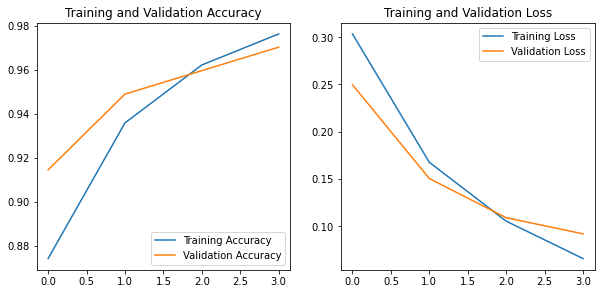

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(xBin_test)
#predictions = model.predict(xBin_test)
#predictions = predictions.reshape(1,-1)[0]

In [11]:
pred = [int(round(x[0])) for x in predictions]

In [12]:
print(yBin_test.shape)

(6560,)


In [13]:
from sklearn.metrics import accuracy_score
print("Accuracy score:",round(accuracy_score(yBin_test, pred),4))
print("Number of correctly classified samples:",accuracy_score(yBin_test, pred, normalize=False))
print(classification_report(yBin_test, pred, target_names = ['Non-COVID (Class 0)','COVID (Class 1)']))

Accuracy score: 0.9703
Number of correctly classified samples: 6365
                     precision    recall  f1-score   support

Non-COVID (Class 0)       0.99      0.97      0.98      5449
    COVID (Class 1)       0.88      0.95      0.92      1111

           accuracy                           0.97      6560
          macro avg       0.94      0.96      0.95      6560
       weighted avg       0.97      0.97      0.97      6560



In [14]:
print('Confusion matrix : \n')
print(confusion_matrix(yBin_test, pred)) #(actual, predicted)

Confusion matrix : 

[[5312  137]
 [  58 1053]]


Categorical

In [5]:
xCat_train, xCat_test, yCat_train, yCat_test = train_test_split(X, Ycat, test_size=0.3, random_state=1)

In [6]:
Categorical_model = Sequential()

Categorical_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))

#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

Categorical_model.add(Flatten())
Categorical_model.add(Dense(128, activation='relu'))
Categorical_model.add(Dense(5, activation='softmax'))

Categorical_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 128)               264257664 
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 264,259,205
Trainable params: 264,259,205
Non-trainable params: 0
_________________________________________________________________


In [7]:
adam = Adam()
#Categorical_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=adam, metrics=['accuracy'])
Categorical_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [8]:
f = Categorical_model.fit(xCat_train, yCat_train, epochs = 3, validation_data=(xCat_test, yCat_test))

Epoch 1/3
479/479 [==============================] - 1234s 3s/step - loss: 6.4802 - accuracy: 0.7030 - val_loss: 0.5850 - val_accuracy: 0.7887
Epoch 2/3
479/479 [==============================] - 1195s 2s/step - loss: 0.4549 - accuracy: 0.8333 - val_loss: 0.5316 - val_accuracy: 0.8058
Epoch 3/3
479/479 [==============================] - 1189s 2s/step - loss: 0.2924 - accuracy: 0.9017 - val_loss: 0.5916 - val_accuracy: 0.8078


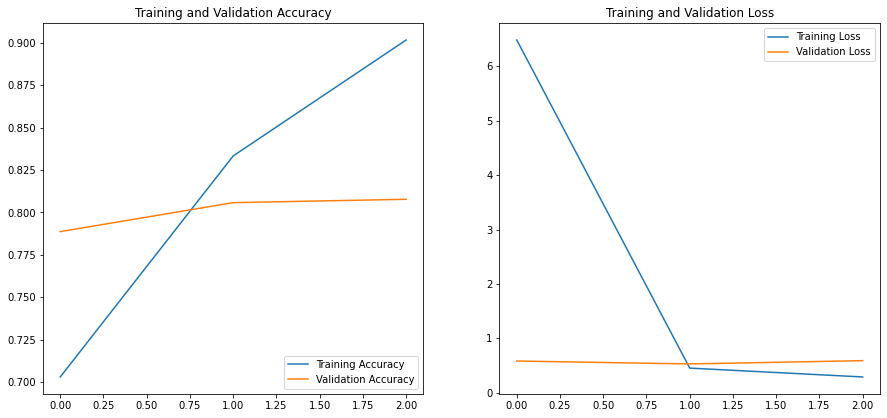

In [9]:
acc = f.history['accuracy']
val_acc = f.history['val_accuracy']
loss = f.history['loss']
val_loss = f.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = Categorical_model.predict(xCat_test)
predicted = np.argmax(predictions, axis = 1)
yCat_test=np.argmax(yCat_test, axis=1)

In [27]:
print(predicted.shape)

(6560,)


In [11]:
#print(pd.crosstab(y_test, predicted))
print(pd.crosstab(yCat_test, predicted))

col_0     0     1    2    3    4
row_0                           
0      2821   168   43    3   37
1       571  1104    4    0   74
2        19     7  372    0    6
3        30     9    2  150   29
4       182    66   10    1  852


In [12]:
print(classification_report(yCat_test, predicted))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      3072
           1       0.82      0.63      0.71      1753
           2       0.86      0.92      0.89       404
           3       0.97      0.68      0.80       220
           4       0.85      0.77      0.81      1111

    accuracy                           0.81      6560
   macro avg       0.86      0.78      0.81      6560
weighted avg       0.81      0.81      0.80      6560

